# Drought hazard team rainfall percentile output processing

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice
sys.path.append('/g/data/mn51/users/jb6465/drought-github/percentiles_spi_spei_smi')
import utils

#### BC SWITCH (toggle on / off)

In [29]:
BC_SWITCH = True

## GWL slicing

In [2]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 40fe88fca1eaab8491bb3a5b99167db817b24c65


### 10-50-90 Percentiles for GWL and change between GWLs

In [17]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*p15*{}".format(input_dir, '.nc'))))

In [18]:
files

['/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.5_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL2.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL3.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1

In [26]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing 10-50-90th percentiles of MME for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"10th, 50th and 90th percentile of MME for 15th percentile threshold using base period of GWL{str(GWL)}."
    p10_50_90_xr.attrs['comment'] = f"Using data on {input_dir}"
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    file_name = f"{output_dir}p15_3month_GWL_{str(GWL)}_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}p15_3month_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
    p10_50_90_xr.to_netcdf(file_name, mode='w')

    #10-50-90th percentile of percent change 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')
            
        MME_change_p10_50_90 = (MME_xr-MME_GWL12_xr).quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"Change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of MME for 15th percentile threshold using base period of GWL{str(GWL)}."
        MME_change_p10_50_90.attrs['comment'] = f"Using data on {input_dir}"
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        file_name = f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        MME_change_p10_50_90.to_netcdf(file_name, mode='w')

Computing 10-50-90th percentiles of MME for GWL1.2
Computing 10-50-90th percentiles of MME for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


GWL1.5-GWL1.2


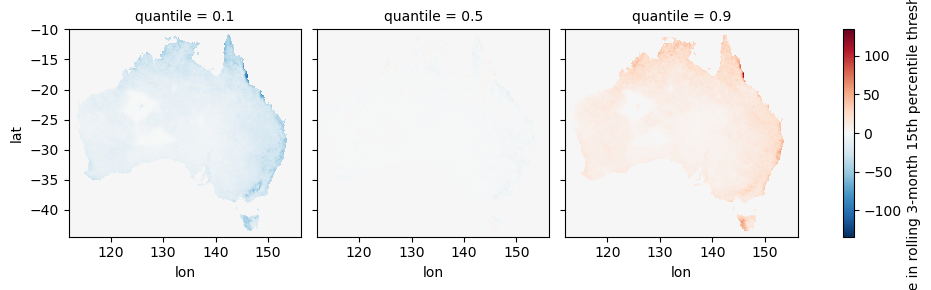

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

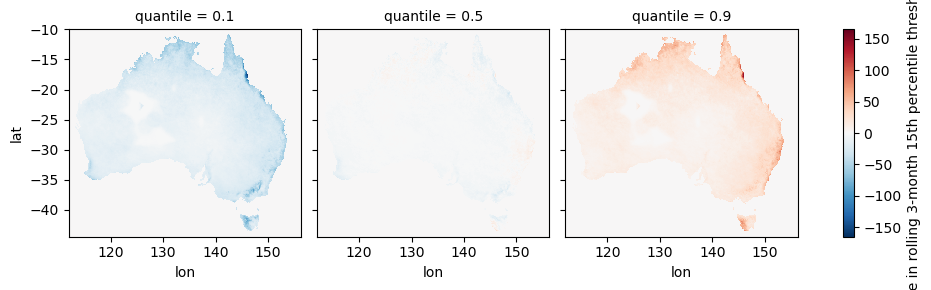

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

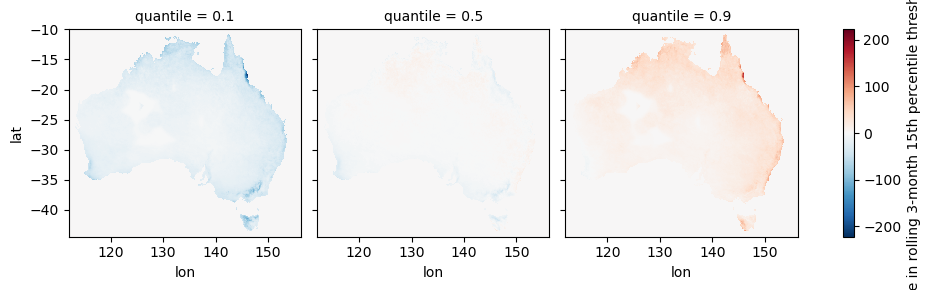

<Figure size 640x480 with 0 Axes>

In [27]:
#quick check of outputs
for GWL in [1.5, 2.0, 3.0]:
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc")
    (quick_check_ds.p15_3month.mean(dim='month')).plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in rolling 3-month 15th percentile threshold (mm)'})
    plt.show()
    plt.clf()

### Plotting

In [10]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [11]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

In [15]:
# %%time
# plot_acs_hazard(data = xr.open_dataset('/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_GWL2.0_ACS-QME-AGCD-1960-2022.nc').sel(month='DJF').p15_3month,
#                     regions = regions_dict['ncra_regions'],
#                     cmap = cmap_dict["pr"],
#                     ticks = tick_dict["pr_mon"],
#                     cbar_label = "15th Percentile threshold (mm)",
#                     cbar_extend = "max",
#                     title = "BARPA-R ACCESS-ESM1-5 NDJ 15th Percentile threshold (GWL=2.0)",
#                     dataset_name = "BARPA-R",
#                     date_range = "November-December-January",
#                    );

CPU times: user 1min 21s, sys: 801 ms, total: 1min 22s
Wall time: 1min 25s


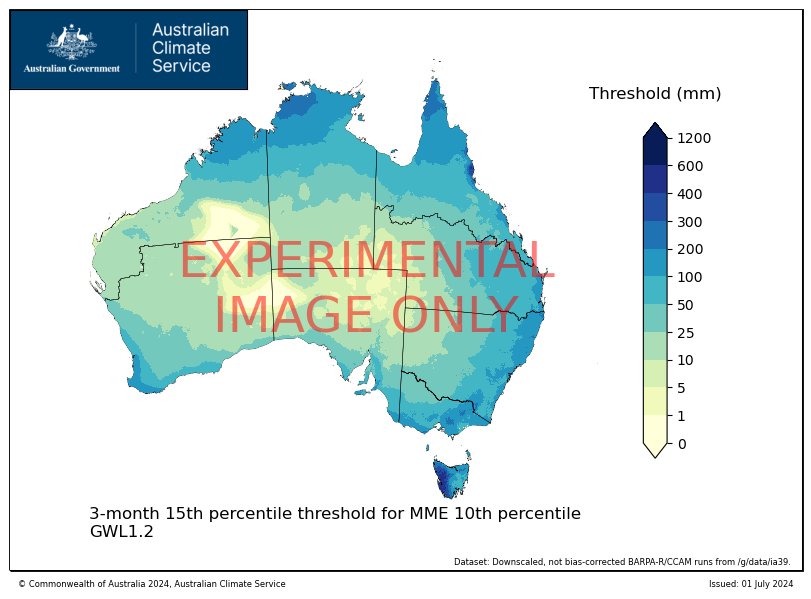

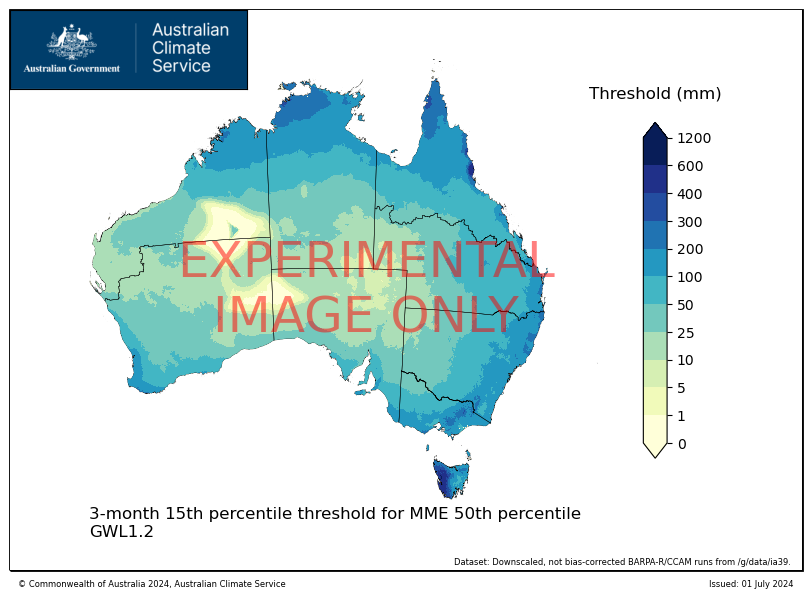

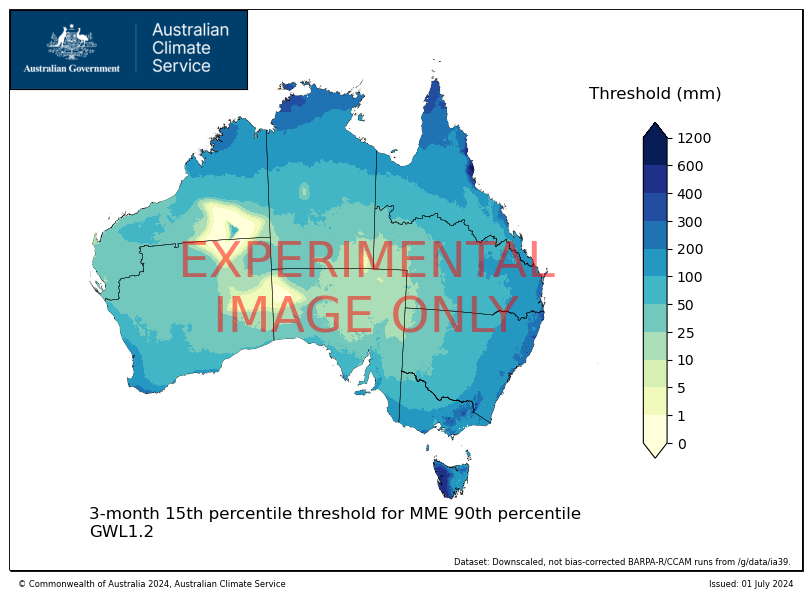

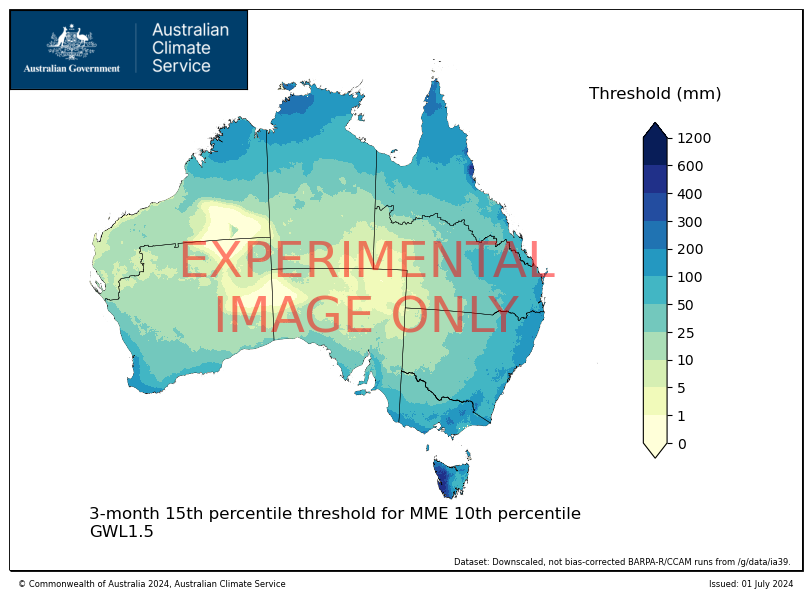

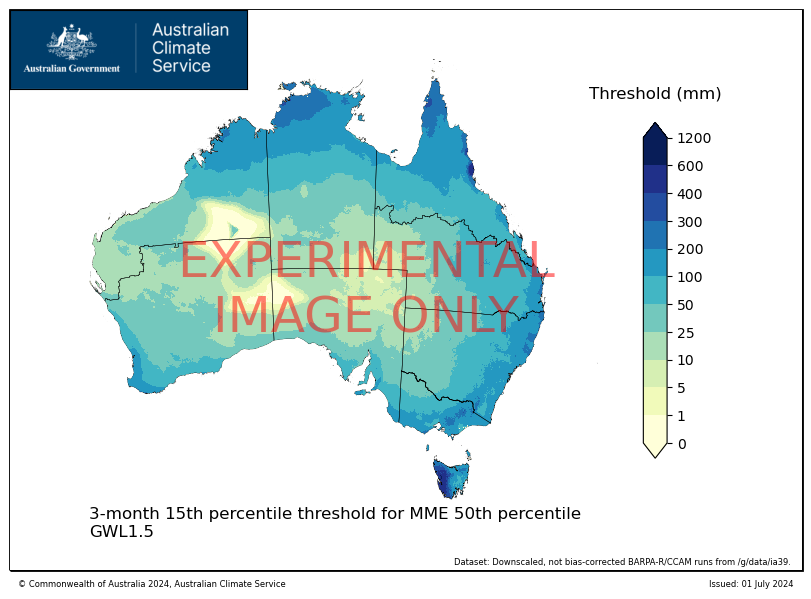

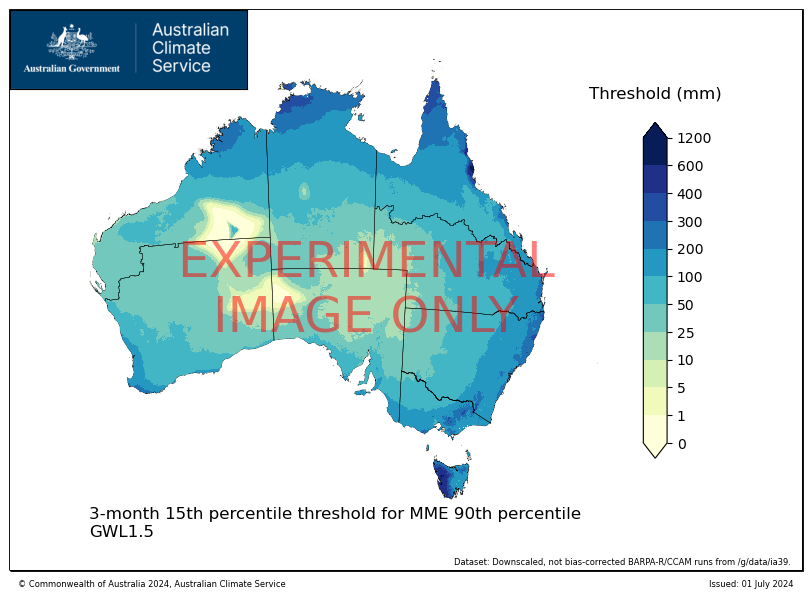

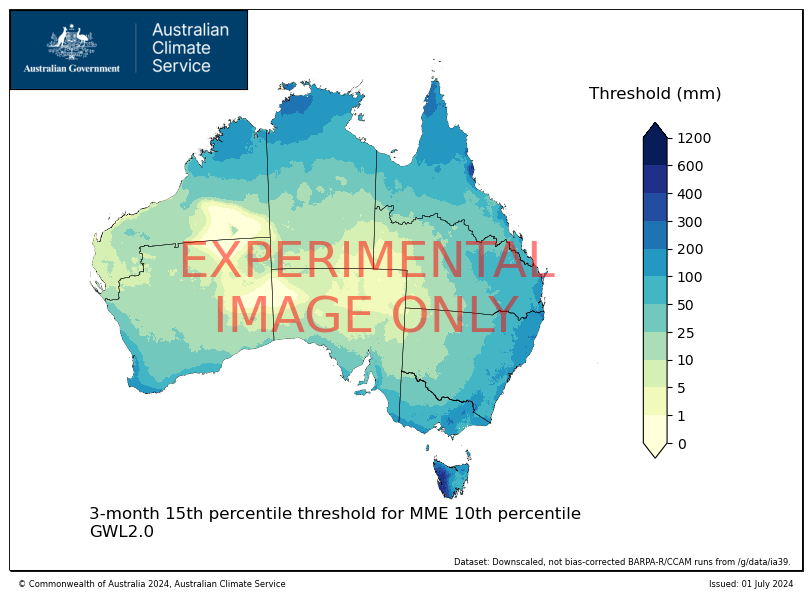

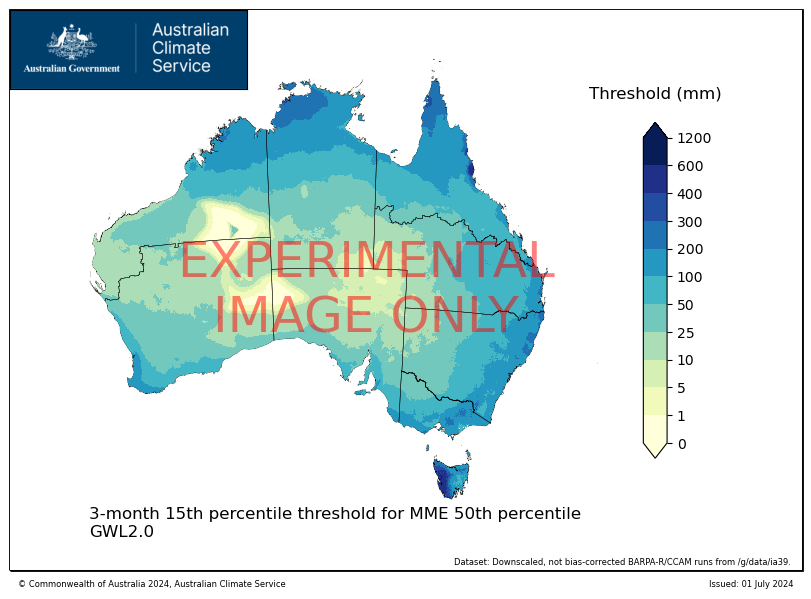

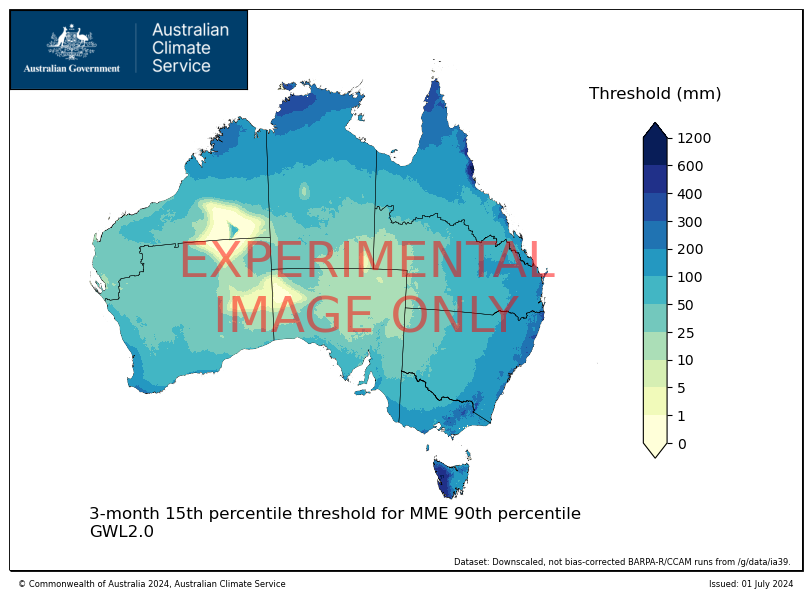

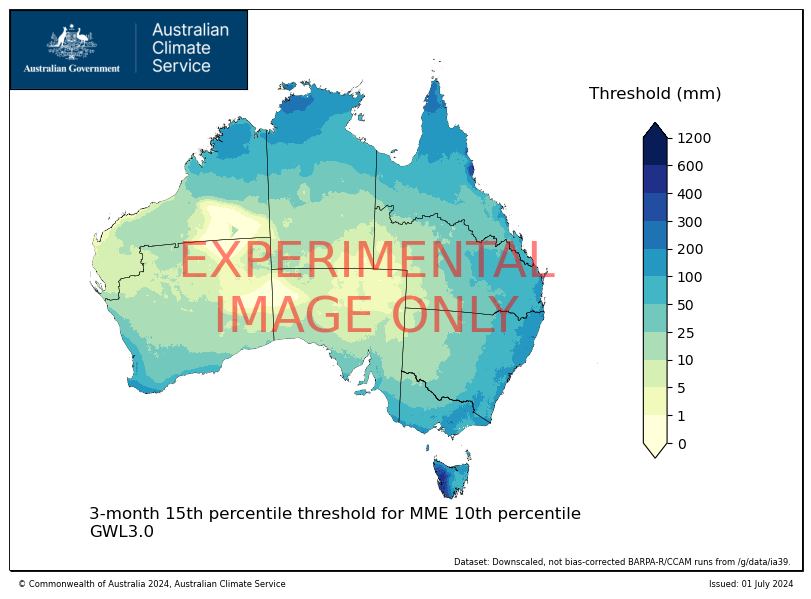

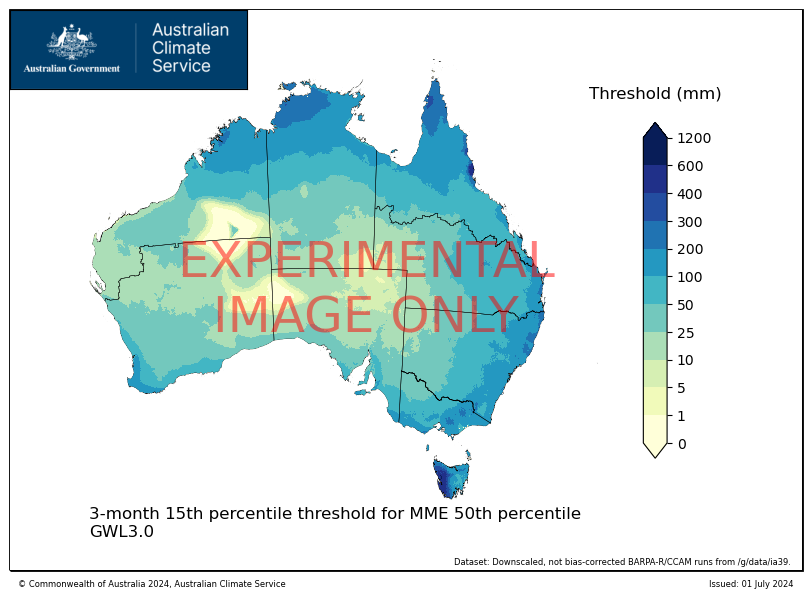

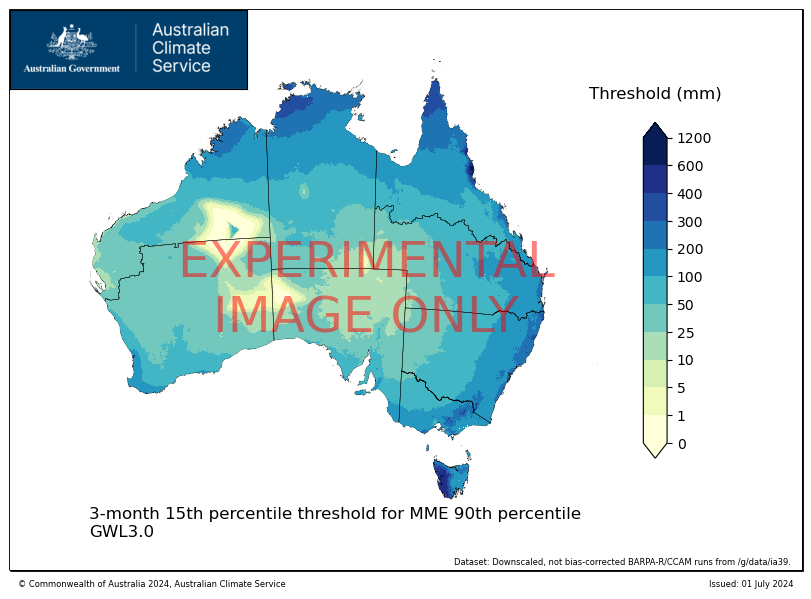

In [24]:
%%time
for GWL in [1.2, 1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        if BC_SWITCH:
            plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/p15_3month_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        else:
            plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/p15_3month_GWL_{str(GWL)}_percentiles_10-50-90.nc"
        plot_acs_hazard(data = xr.open_dataset(plot_file).sel(quantile=percentile).p15_3month.mean(dim='month'),
        regions = regions_dict['ncra_regions'],
        cmap = cmap_dict["pr"],
        ticks = tick_dict["pr_mon"],
        cbar_label = "Threshold (mm)",
        cbar_extend = "both",
        title = f"3-month 15th percentile threshold for MME {str(int(percentile*100))}th percentile",
        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39. ",
        date_range = f"GWL{str(GWL)}",
        contourf = False,
        contour = False,
        outfile = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/figures/p15_3month_GWL{str(GWL)}_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/figures/p15_3month_GWL{str(GWL)}_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}.png"
        );


CPU times: user 59.1 s, sys: 316 ms, total: 59.4 s
Wall time: 59.5 s


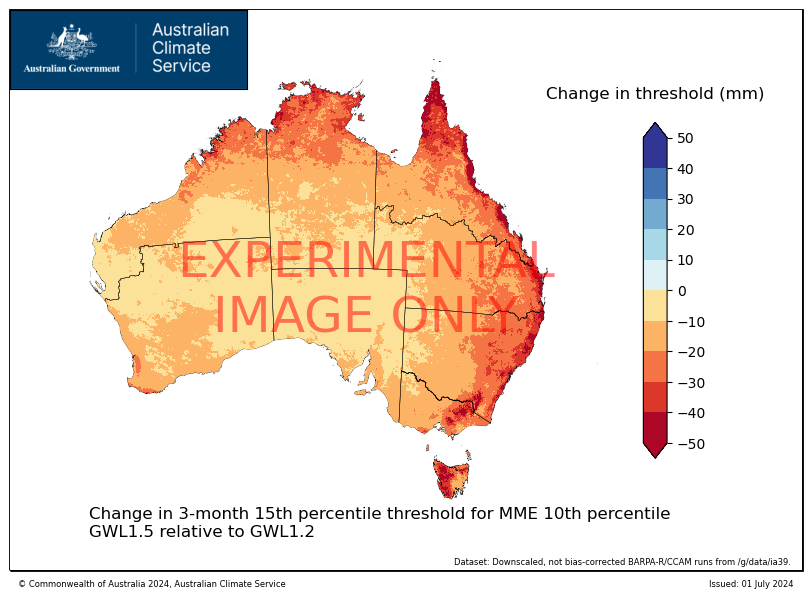

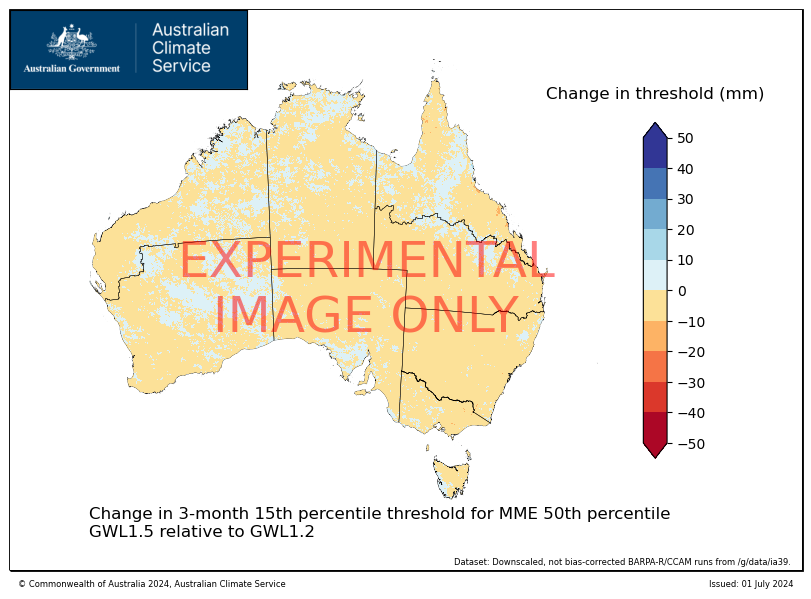

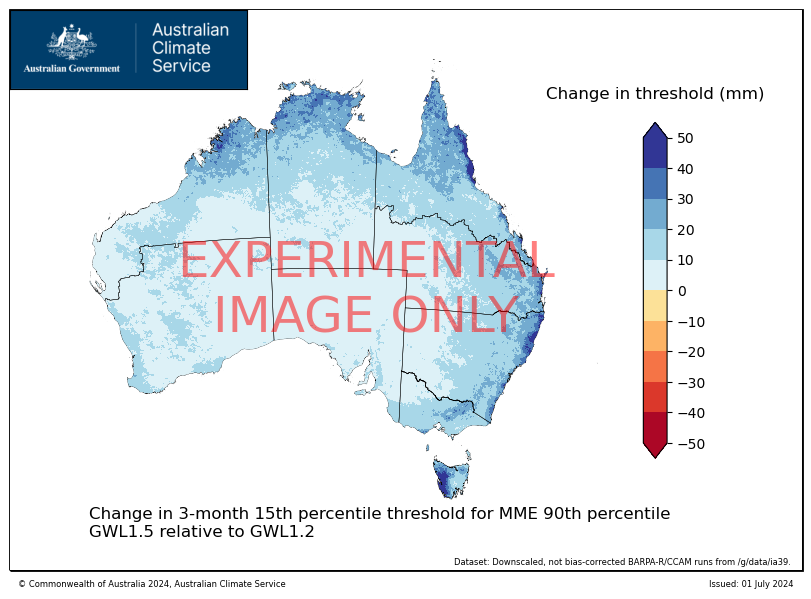

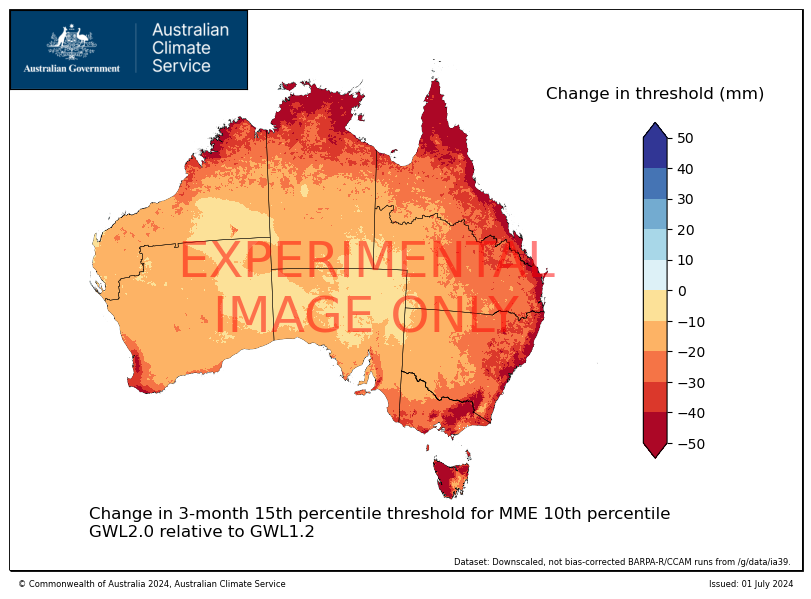

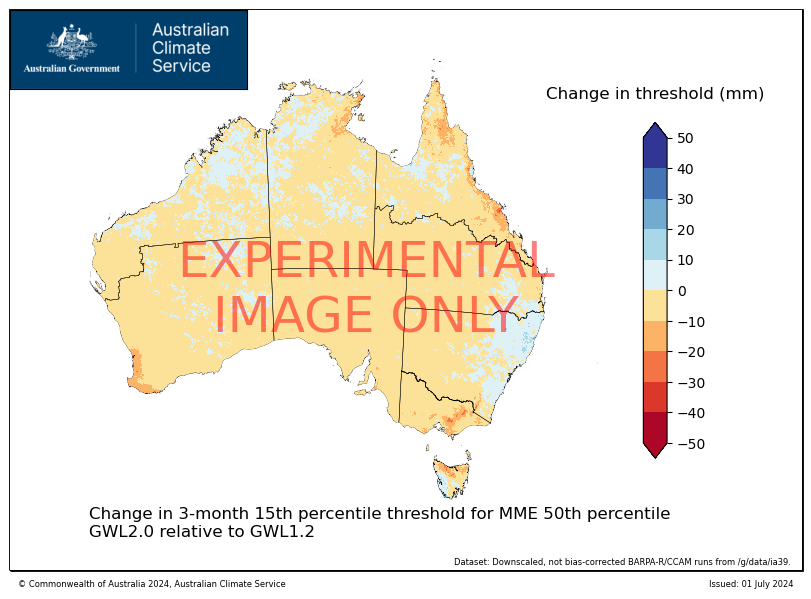

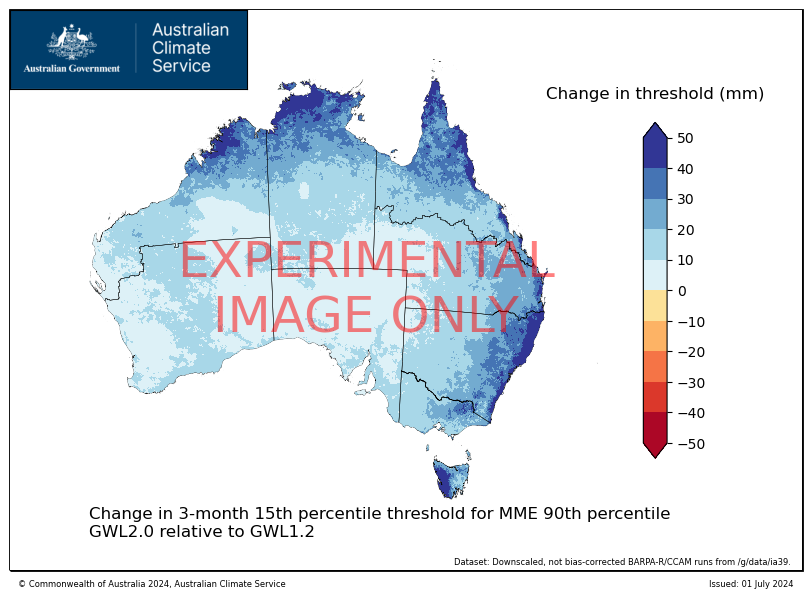

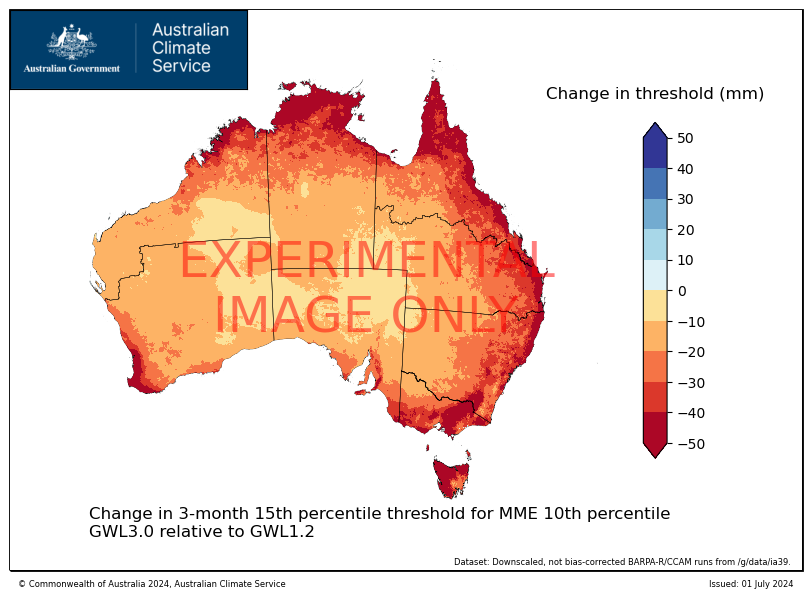

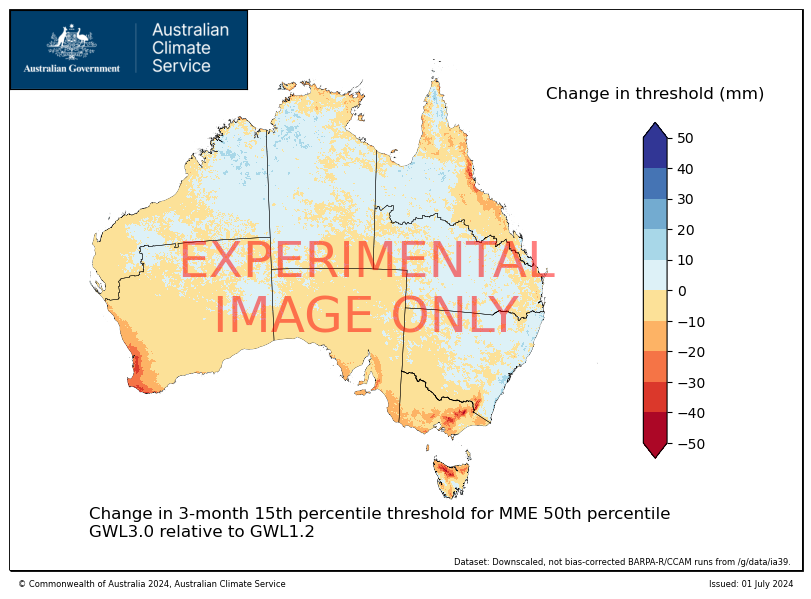

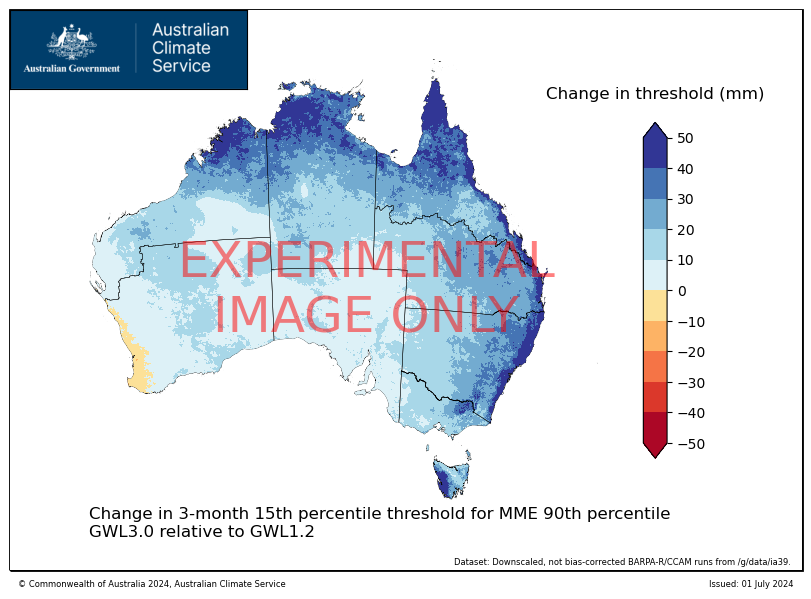

In [30]:
%%time
for GWL in [1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        if BC_SWITCH:
            plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        else:
            plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc"
        plot_acs_hazard(data = xr.open_dataset(plot_file).sel(quantile=percentile).p15_3month.mean(dim='month'),
        regions = regions_dict['ncra_regions'],
        cmap = cmap_dict["anom_b2r_r"],
        ticks = np.arange(-50, 50.1, 10),
        cbar_label = "Change in threshold (mm)",
        cbar_extend = "both",
        title = f"Change in 3-month 15th percentile threshold for MME {str(int(percentile*100))}th percentile",
        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39. ",
        date_range = f"GWL{str(GWL)} relative to GWL1.2",
        contourf = False,
        contour = False,
        outfile = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/figures/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/figures/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}.png"
        );




## Regional statistics

In [15]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [16]:
from acs_area_statistics import acs_regional_stats, regions

In [17]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*MME_change*{}".format(input_dir, '.nc'))))

In [18]:
files

['/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/p15_3month_MME_change_GWL1.5_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/p15_3month_MME_change_GWL2.0_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/p15_3month_MME_change_GWL3.0_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc']

In [19]:
from IPython.display import display


for change_grid in files:
    for percentile in [0.1, 0.5, 0.9]:
        if BC_SWITCH:
            print_line = f'--> Calculating spatial summary statistics for {change_grid[-63:-47].replace("_", " ")} for {str(int(percentile*100))}th MME percentile.'
            save_line = f'/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/MME_change_spatial_summary_statistics/{change_grid[-63:-47]}_change_for_MME_{str(int(percentile*100))}th_percentile_BC.csv'
        else:
            print_line = f'--> Calculating spatial summary statistics for {change_grid[-40:-24].replace("_", " ")} for {str(int(percentile*100))}th MME percentile.'
            save_line = f'/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/MME_change_spatial_summary_statistics/{change_grid[-40:-24]}_change_for_MME_{str(int(percentile*100))}th_percentile.csv'
        print(print_line)
        print()
        
        ds = xr.open_dataset(change_grid).mean(dim='month').sel(quantile=percentile)
        ds = ds.rename({'p15_3month': 'change_in_p15_3month_threshold'})
        mask_frac = regions.mask_3D_frac_approx(ds)
        dims = ("lat", "lon",)
        regional_summary_ds = acs_regional_stats(ds=ds,var="change_in_p15_3month_threshold", mask=mask_frac, dims = dims, how = ["min", "median", "max"])
        display(regional_summary_ds)
        
        regional_summary_ds.to_csv(save_line)

--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_min,change_in_p15_3month_threshold_median
region,,,,
0,WANorth,Western Australia North,-45.633977,-11.356368
1,WASouth,Western Australia South,-35.590459,-8.843348
2,NSW,New South Wales and Australian Capital Territory,-60.385874,-18.207229
3,VIC,Victoria,-72.840937,-16.529472
4,SA,South Australia,-24.080520,-6.954465
5,TAS,Tasmania,-59.055488,-28.416483
6,NT,Northern Territory,-55.589850,-12.782795
7,QLDNorth,Queensland North,-128.578158,-20.810760
8,QLDSouth,Queensland South,-55.655073,-14.751576


--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_min,change_in_p15_3month_threshold_median,change_in_p15_3month_threshold_max
region,,,,,
0,WANorth,Western Australia North,-7.582472,-0.426801,9.329297
1,WASouth,Western Australia South,-7.765336,-0.214681,2.269076
2,NSW,New South Wales and Australian Capital Territory,-15.052548,-1.676776,6.391732
3,VIC,Victoria,-13.368815,-1.074562,2.519043
4,SA,South Australia,-3.367240,-0.506120,2.209194
5,TAS,Tasmania,-9.667611,-1.507198,12.226490
6,NT,Northern Territory,-11.441081,-0.814683,8.015495
7,QLDNorth,Queensland North,-17.437174,-0.935249,16.141178
8,QLDSouth,Queensland South,-10.184278,-1.177930,4.748796


--> Calculating spatial summary statistics for GWL1.5 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_median,change_in_p15_3month_threshold_max
region,,,,
0,WANorth,Western Australia North,10.570471,47.812780
1,WASouth,Western Australia South,8.416785,22.161160
2,NSW,New South Wales and Australian Capital Territory,12.545024,59.701289
3,VIC,Victoria,13.172512,39.397975
4,SA,South Australia,5.575706,19.536374
5,TAS,Tasmania,22.750834,70.725560
6,NT,Northern Territory,11.198391,44.217096
7,QLDNorth,Queensland North,17.226483,134.013678
8,QLDSouth,Queensland South,10.910429,50.152362


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_min,change_in_p15_3month_threshold_median
region,,,,
0,WANorth,Western Australia North,-67.352031,-15.854536
1,WASouth,Western Australia South,-60.147460,-13.350713
2,NSW,New South Wales and Australian Capital Territory,-85.611974,-21.567835
3,VIC,Victoria,-110.294440,-26.678919
4,SA,South Australia,-45.836942,-9.729068
5,TAS,Tasmania,-97.549056,-40.364517
6,NT,Northern Territory,-78.626016,-17.910214
7,QLDNorth,Queensland North,-164.042900,-30.357568
8,QLDSouth,Queensland South,-75.847871,-20.525201


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_min,change_in_p15_3month_threshold_median,change_in_p15_3month_threshold_max
region,,,,,
0,WANorth,Western Australia North,-19.387272,-0.583003,12.005501
1,WASouth,Western Australia South,-23.728941,-1.397696,2.279134
2,NSW,New South Wales and Australian Capital Territory,-26.095452,-1.062933,23.992708
3,VIC,Victoria,-28.544499,-5.330295,1.723385
4,SA,South Australia,-13.250799,-1.658804,0.557617
5,TAS,Tasmania,-25.244596,-3.348091,29.810297
6,NT,Northern Territory,-22.134961,-1.493197,13.098780
7,QLDNorth,Queensland North,-33.883270,-3.412813,18.812370
8,QLDSouth,Queensland South,-19.678297,-2.232961,10.684695


--> Calculating spatial summary statistics for GWL2.0 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_median,change_in_p15_3month_threshold_max
region,,,,
0,WANorth,Western Australia North,13.814612,59.069596
1,WASouth,Western Australia South,9.337683,20.024531
2,NSW,New South Wales and Australian Capital Territory,19.843422,83.357982
3,VIC,Victoria,17.521304,51.742201
4,SA,South Australia,7.174596,22.238225
5,TAS,Tasmania,27.955439,93.613529
6,NT,Northern Territory,15.089475,76.437323
7,QLDNorth,Queensland North,23.620974,155.902676
8,QLDSouth,Queensland South,14.565353,60.831376


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 10th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_min,change_in_p15_3month_threshold_median
region,,,,
0,WANorth,Western Australia North,-79.679629,-15.636059
1,WASouth,Western Australia South,-72.304141,-13.525661
2,NSW,New South Wales and Australian Capital Territory,-102.977114,-21.655715
3,VIC,Victoria,-125.284199,-32.450888
4,SA,South Australia,-61.718080,-10.108185
5,TAS,Tasmania,-126.569154,-49.450664
6,NT,Northern Territory,-112.257956,-17.660079
7,QLDNorth,Queensland North,-220.932569,-31.357858
8,QLDSouth,Queensland South,-79.753674,-17.443349


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 50th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_min,change_in_p15_3month_threshold_median,change_in_p15_3month_threshold_max
region,,,,,
0,WANorth,Western Australia North,-25.230951,0.055810,16.621452
1,WASouth,Western Australia South,-39.435672,-1.858022,3.499740
2,NSW,New South Wales and Australian Capital Territory,-42.813958,0.197885,21.021745
3,VIC,Victoria,-46.154720,-7.589423,1.854410
4,SA,South Australia,-28.509214,-1.460607,2.733298
5,TAS,Tasmania,-49.237012,-8.640740,31.903255
6,NT,Northern Territory,-26.716098,1.091623,16.206836
7,QLDNorth,Queensland North,-37.981706,0.138190,21.785352
8,QLDSouth,Queensland South,-14.562798,0.733702,9.930211


--> Calculating spatial summary statistics for GWL3.0 to GWL1.2 for 90th MME percentile.



,abbrevs,names,change_in_p15_3month_threshold_min,change_in_p15_3month_threshold_median,change_in_p15_3month_threshold_max
region,,,,,
0,WANorth,Western Australia North,-1.471721,15.689545,76.580111
1,WASouth,Western Australia South,-14.664670,8.126345,22.607168
2,NSW,New South Wales and Australian Capital Territory,0.000000,21.254489,93.304897
3,VIC,Victoria,0.000000,14.842216,52.498242
4,SA,South Australia,-0.002016,7.789452,18.910462
5,TAS,Tasmania,0.000000,23.816543,96.171414
6,NT,Northern Territory,0.000000,21.160088,74.371890
7,QLDNorth,Queensland North,0.000000,30.658125,181.145996
8,QLDSouth,Queensland South,0.000000,20.781767,73.092538
